In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.interpolate import CubicSpline

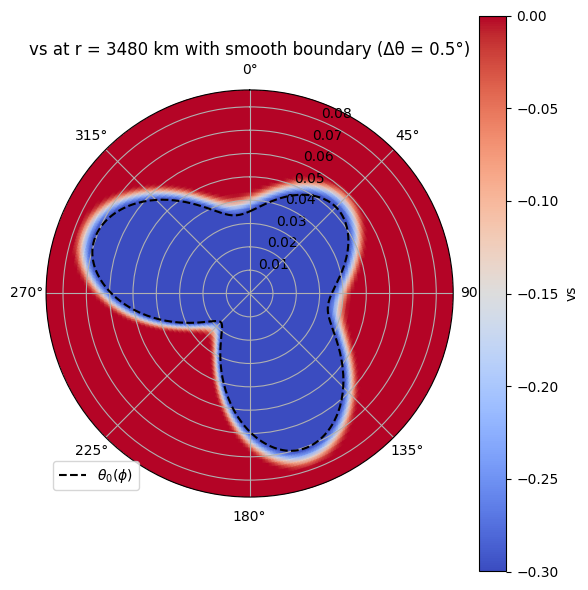

In [2]:
# === Grid setup ===
theta_deg = np.arange(0, 5.01, 0.1)  # θ from 0° to 5°, step 0.1°
phi_deg = np.arange(0, 360.01, 1.0)  # φ from 0° to 360°, step 1°
theta_rad = np.radians(theta_deg)
phi_rad = np.radians(phi_deg)
TH, PHI = np.meshgrid(theta_rad, phi_rad, indexing='ij')  # shape: (51, 361)

# === Define irregular shape using periodic spline ===
phi_control = np.array([0, 60, 120, 180, 240, 300, 360]) + 45
theta_control = np.array([3, 2, 4, 1, 4, 2, 3])  # in degrees
phi_spline = CubicSpline(phi_control, theta_control, bc_type='periodic')
theta0_vals_deg = phi_spline(phi_deg)
theta0_vals_rad = np.radians(theta0_vals_deg)
theta0_grid = theta0_vals_rad[np.newaxis, :]  # shape: (1, 361)

# === Define smooth decay zone ===
delta_deg = 0.5  # smoothing thickness in degrees
delta_rad = np.radians(delta_deg)
vs = np.zeros_like(TH)
full_value = -0.3

# Inside: θ < θ₀
vs[TH < theta0_grid] = full_value

# Transition zone: θ₀ ≤ θ ≤ θ₀ + Δθ
in_transition = (TH >= theta0_grid) & (TH <= theta0_grid + delta_rad)
theta_rel = (TH - theta0_grid)[in_transition] / delta_rad  # range [0, 1]
vs[in_transition] = full_value * 0.5 * (1 + np.cos(np.pi * theta_rel))

# === Polar plot ===
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
pcm = ax.pcolormesh(PHI, TH, vs, shading='gouraud', cmap='coolwarm')
fig.colorbar(pcm, ax=ax, label='vs')

# Overlay θ₀(φ) boundary
ax.plot(phi_rad, theta0_vals_rad, 'k--', linewidth=1.5, label=r'$\theta_0(\phi)$')

# Aesthetics
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title(f"vs at r = 3480 km with smooth boundary (Δθ = {delta_deg}°)")
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()


In [3]:
import numpy as np

# === Prepare vs, vp, rho arrays ===
r_vals = np.array([3480, 3500], dtype=np.float32)  # in km
theta_vals = np.array(theta_deg, dtype=np.float32)  # in degrees
phi_vals = np.array(phi_deg, dtype=np.float32)  # in degrees

# Duplicate vs pattern to both radii
vs_full = np.stack([vs, vs], axis=0).astype(np.float32)  # shape: (2, theta, phi)
vp_full = (vs_full / -0.3 * -0.1).astype(np.float32)
rho_full = (vs_full / -0.3 * 0.05).astype(np.float32)

# === Create xarray Dataset ===
ds = xr.Dataset(
    data_vars=dict(
        vs=(["radius", "theta", "phi"], vs_full),
        vp=(["radius", "theta", "phi"], vp_full),
        rho=(["radius", "theta", "phi"], rho_full),
    ),
    coords=dict(
        radius=("radius", r_vals),  # km
        theta=("theta", theta_vals),  # degrees
        phi=("phi", phi_vals),  # degrees
    ),
    attrs=dict(description="vs, vp, rho in spherical shell with smooth θ-boundary")
)

# === Save to NetCDF ===
ds.to_netcdf("ulvz.nc")

In [4]:
ds = xr.open_dataset("ulvz.nc")
for key in ["radius", "theta", "phi", "vs", "vp", "rho"]:
    print(key, ds[key].shape, ds[key].dtype, ds[key].min().values, ds[key].max().values)

radius (2,) float32 3480.0 3500.0
theta (51,) float32 0.0 5.0
phi (361,) float32 0.0 360.0
vs (2, 51, 361) float32 -0.3 0.0
vp (2, 51, 361) float32 -0.1 0.0
rho (2, 51, 361) float32 -0.0 0.05
